In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '42-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [18]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 25,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 5,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB3',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 25,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 5,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 3.43e-06


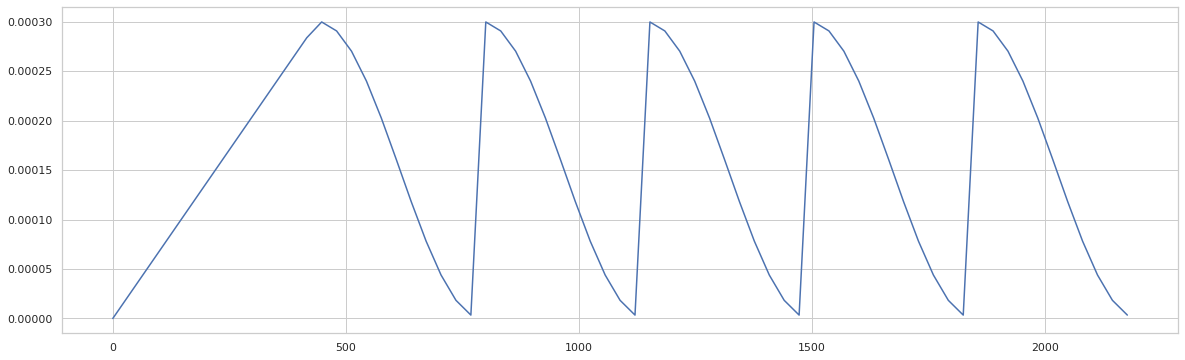

In [16]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch  = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch 
hold_max_steps = 0
warmup_steps = steps_per_epoch  * 5
num_cycles = 5

rng = [i for i in range(0, total_steps, 32)]
y = [cosine_with_hard_restarts_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                                    warmup_steps=warmup_steps, lr_start=lr_start, 
                                                    lr_max=lr_max, lr_min=lr_min, num_cycles=num_cycles) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [19]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: cosine_with_hard_restarts_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                    total_steps=total_steps, warmup_steps=warmup_steps, 
                                                                    lr_start=lr_start, lr_max=lr_max, lr_min=lr_min, 
                                                                    num_cycles=num_cycles)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            optimizer = tfa.optimizers.SWA(optimizer, start_averaging=int(steps_per_epoch * 5), average_period=int(steps_per_epoch * 4))
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        # Make predictions (last model)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
        
        # Make predictions (best model)
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.61.200.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.200.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/25
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


93/93 - 40s - auc: 0.5948 - loss: 0.5294 - val_auc: 0.6281 - val_loss: 0.3453
Epoch 2/25
93/93 - 26s - auc: 0.8693 - loss: 0.2841 - val_auc: 0.8185 - val_loss: 0.3131
Epoch 3/25
93/93 - 26s - auc: 0.8977 - loss: 0.2661 - val_auc: 0.8792 - val_loss: 0.2788
Epoch 4/25
93/93 - 27s - auc: 0.9130 - loss: 0.2548 - val_auc: 0.9161 - val_loss: 0.2522
Epoch 5/25
93/93 - 24s - auc: 0.9230 - loss: 0.2456 - val_auc: 0.9254 - val_loss: 0.2589
Epoch 6/25
93/93 - 25s - auc: 0.9358 - loss: 0.2355 - val_auc: 0.9447 - val_loss: 0.2266
Epoch 7/25
93/93 - 25s - auc: 0.9461 - loss: 0.2245 - val_auc: 0.9441 - val_loss: 0.2254
Epoch 8/25
93/93 - 25s - auc: 0.9533 - loss: 0.2173 - val_auc: 0.9509 - val_loss: 0.2165
Epoch 9/25
93/93 - 23s - auc: 0.9524 - loss: 0.2164 - val_auc: 0.9455 - val_loss: 0.2235
Epoch 10/25
93/93 - 24s - auc: 0.9514 - loss: 0.2178 - val_auc: 0.9408 - val_loss: 0.2237
Epoch 11/25
93/93 - 25s - auc: 0.9605 - loss: 0.2075 - val_auc: 0.9535 - val_loss: 0.2123
Epoch 12/25
93/93 - 25s - auc:

INFO:tensorflow:Initializing the TPU system: grpc://10.61.200.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.200.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/25
93/93 - 41s - auc: 0.5588 - loss: 0.5655 - val_auc: 0.6281 - val_loss: 0.3506
Epoch 2/25
93/93 - 26s - auc: 0.8640 - loss: 0.2852 - val_auc: 0.8021 - val_loss: 0.3108
Epoch 3/25
93/93 - 26s - auc: 0.8951 - loss: 0.2661 - val_auc: 0.8710 - val_loss: 0.2829
Epoch 4/25
93/93 - 26s - auc: 0.9123 - loss: 0.2541 - val_auc: 0.9040 - val_loss: 0.2673
Epoch 5/25
93/93 - 26s - auc: 0.9265 - loss: 0.2430 - val_auc: 0.9255 - val_loss: 0.2528
Epoch 6/25
93/93 - 26s - auc: 0.9352 - loss: 0.2347 - val_auc: 0.9304 - val_loss: 0.2411
Epoch 7/25
93/93 - 26s - auc: 0.9463 - loss: 0.2243 - val_auc: 0.9415 - val_loss: 0.2280
Epoch 8/25
93/93 - 26s - auc: 0.9561 - loss: 0.2143 - val_auc: 0.9487 - val_loss: 0.2221
Epoch 9/25
93/93 - 24s - auc: 0.9544 - loss: 0.2143 - val_auc: 0.9433 - val_loss: 0.2323
Epoch 10/25
93/93 - 24s - auc: 0.9532 - loss: 0.2162 - val_auc: 0.9478 - val_loss: 0.2242
Epoch 11/25
93/93 - 26s - auc: 0.9615 - loss: 0.2067 - val_auc: 0.9510 - val_loss: 0.2199
Epoch 12/25
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.61.200.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.200.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/25
97/97 - 39s - auc: 0.6013 - loss: 0.5219 - val_auc: 0.6588 - val_loss: 0.3566
Epoch 2/25
97/97 - 27s - auc: 0.8745 - loss: 0.2803 - val_auc: 0.7668 - val_loss: 0.3193
Epoch 3/25
97/97 - 26s - auc: 0.9000 - loss: 0.2623 - val_auc: 0.8799 - val_loss: 0.2788
Epoch 4/25
97/97 - 27s - auc: 0.9176 - loss: 0.2489 - val_auc: 0.9174 - val_loss: 0.2588
Epoch 5/25
97/97 - 26s - auc: 0.9264 - loss: 0.2420 - val_auc: 0.9247 - val_loss: 0.2473
Epoch 6/25
97/97 - 26s - auc: 0.9394 - loss: 0.2311 - val_auc: 0.9340 - val_loss: 0.2399
Epoch 7/25
97/97 - 27s - auc: 0.9500 - loss: 0.2198 - val_auc: 0.9456 - val_loss: 0.2282
Epoch 8/25
97/97 - 26s - auc: 0.9570 - loss: 0.2122 - val_auc: 0.9463 - val_loss: 0.2273
Epoch 9/25
97/97 - 25s - auc: 0.9517 - loss: 0.2173 - val_auc: 0.9421 - val_loss: 0.2332
Epoch 10/25
97/97 - 26s - auc: 0.9561 - loss: 0.2120 - val_auc: 0.9474 - val_loss: 0.2258
Epoch 11/25
97/97 - 27s - auc: 0.9654 - loss: 0.2012 - val_auc: 0.9489 - val_loss: 0.2228
Epoch 12/25
97/97 -

## Model loss graph

Fold: 1


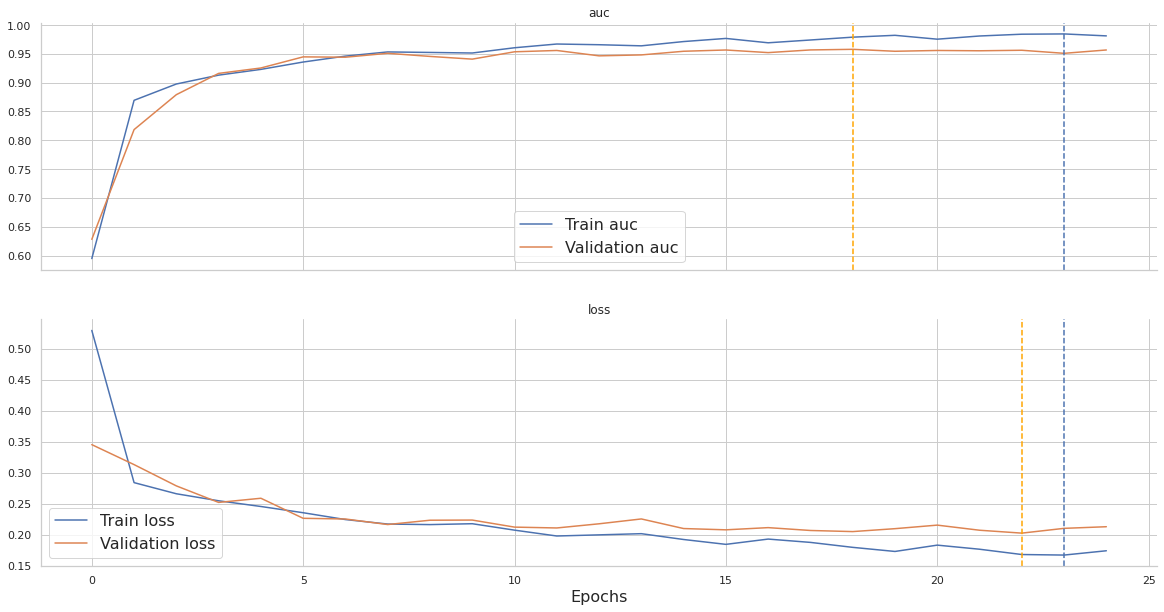

Fold: 2


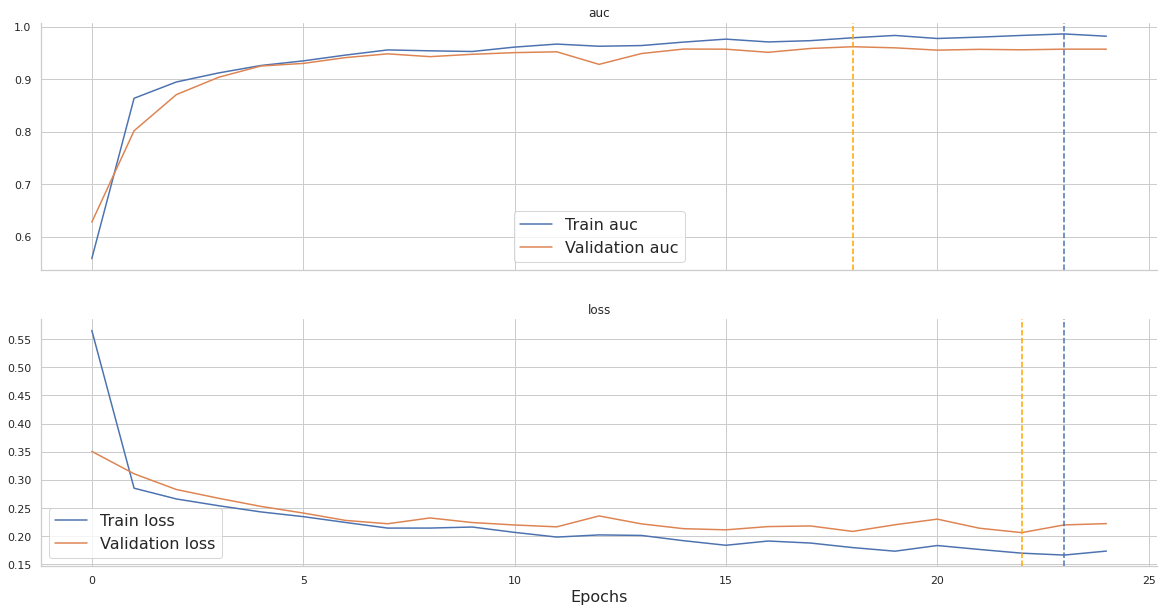

Fold: 3


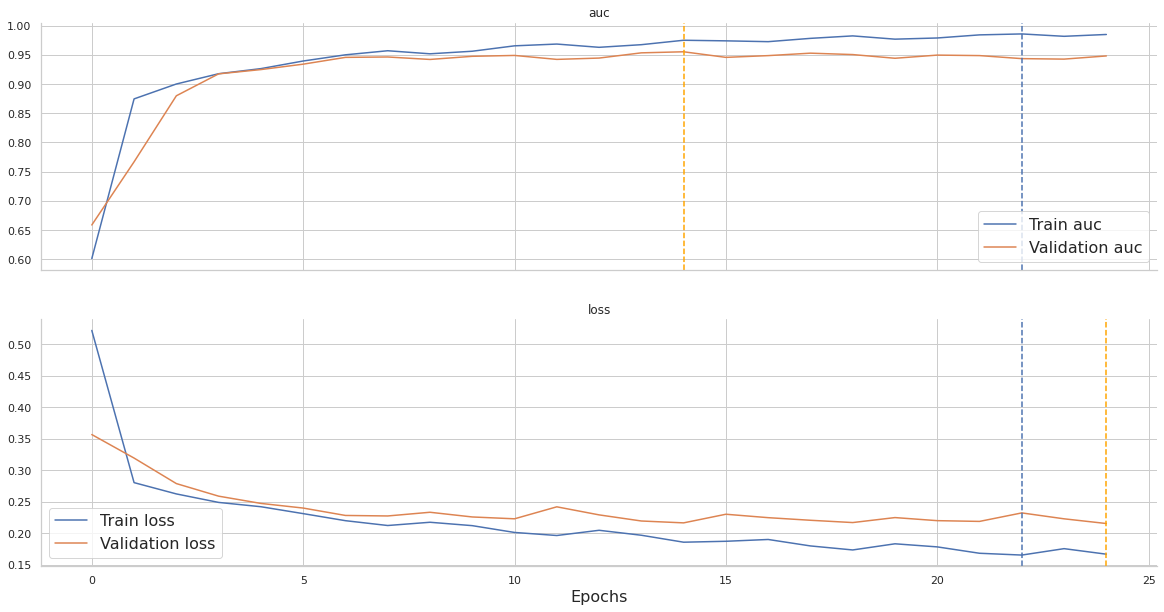

In [20]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

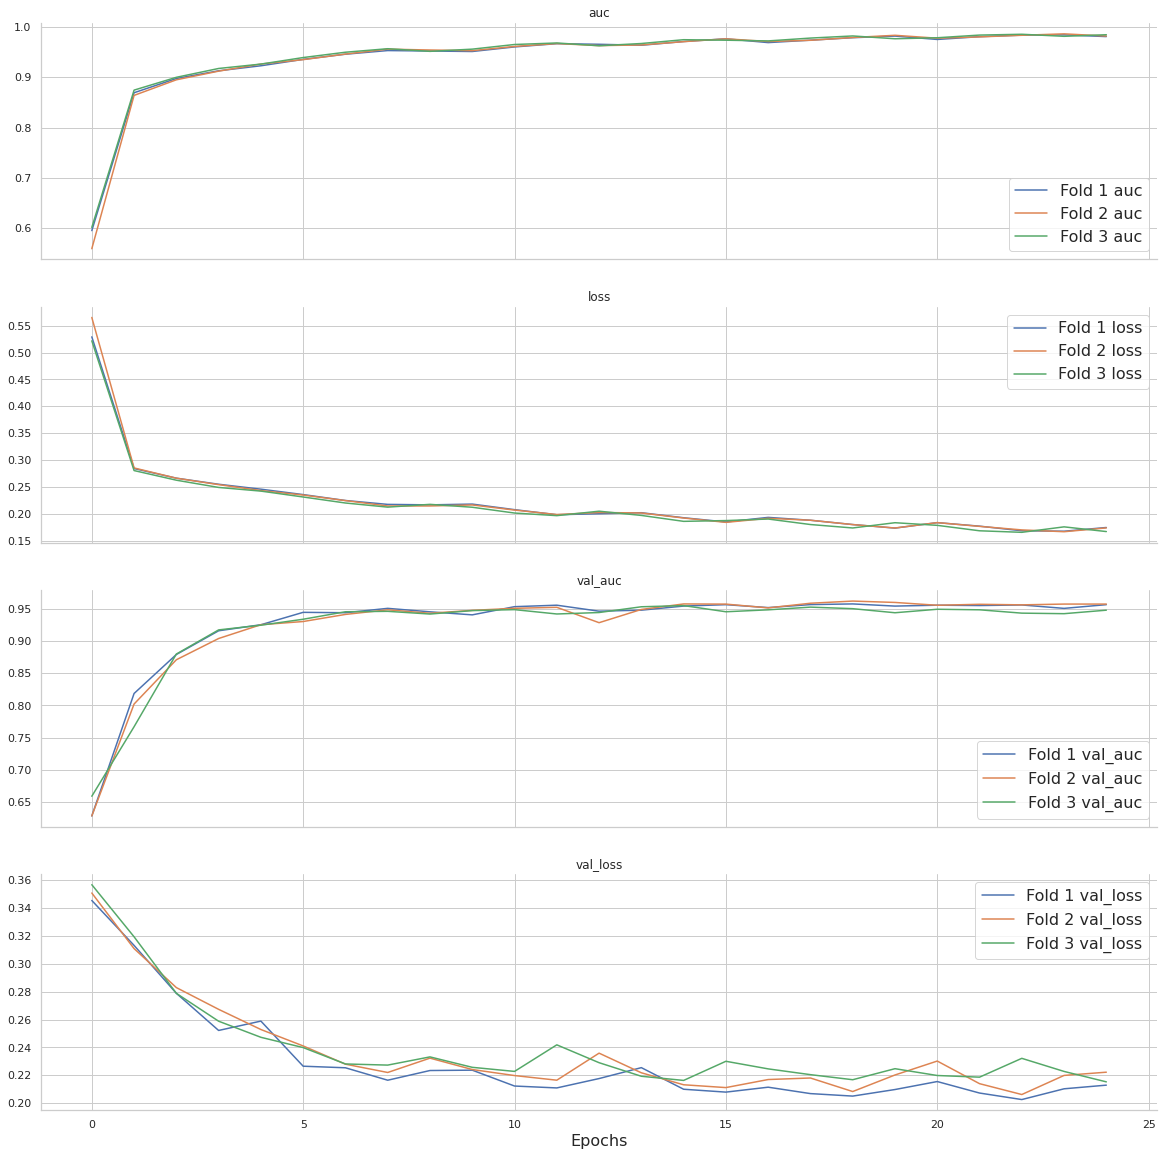

In [21]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [22]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.978783,0.889807,0.088977,0.973390,0.902429,0.979944,0.896090,0.983016,0.870900
Accuracy,0.992422,0.978533,0.013888,0.992153,0.982508,0.990621,0.973932,0.994490,0.979160
Precision,0.851391,0.374882,0.476509,0.859043,0.412698,0.718941,0.307692,0.976190,0.404255
Recall,0.713030,0.256771,0.456259,0.677149,0.242991,0.764069,0.360656,0.697872,0.166667
F1-score,0.770680,0.291328,0.479353,0.757327,0.305882,0.740818,0.332075,0.813896,0.236025
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [23]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.978783,0.889807,0.088977,0.973390,0.902429,0.979944,0.896090,0.983016,0.870900
male,0.981743,0.897405,0.084338,0.979871,0.907116,0.979990,0.908983,0.985368,0.876116
female,0.974002,0.869522,0.104480,0.963028,0.890122,0.979516,0.870335,0.979461,0.848108
head/neck,0.993265,0.896518,0.096747,0.989506,0.948106,0.992630,0.867028,0.997660,0.874420
upper extremity,0.973164,0.883286,0.089878,0.966847,0.897474,0.973513,0.880327,0.979133,0.872058
lower extremity,0.972356,0.838224,0.134132,0.963475,0.866765,0.980359,0.803961,0.973235,0.843947
torso,0.980857,0.910274,0.070583,0.978427,0.900550,0.980562,0.942084,0.983582,0.888190
0 <= age < 26,0.962795,0.817137,0.145658,0.939041,0.882065,0.985552,0.665642,0.963791,0.903704
26 <= age < 40,0.979549,0.910386,0.069163,0.977678,0.879482,0.979466,0.919036,0.981503,0.932640


# Model evaluation (best)

In [24]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.982849,0.879591,0.103258,0.980500,0.909210,0.985006,0.858867,0.983043,0.870697
Accuracy,0.993800,0.980440,0.013360,0.993366,0.982360,0.993507,0.979971,0.994527,0.978990
Precision,0.932894,0.402393,0.530501,0.917127,0.414286,0.905292,0.397059,0.976261,0.395833
Recall,0.699827,0.219669,0.480158,0.696017,0.271028,0.703463,0.221311,0.700000,0.166667
F1-score,0.799500,0.282154,0.517346,0.791418,0.327684,0.791717,0.284211,0.815366,0.234568
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.982849,0.879591,0.103258,0.980500,0.909210,0.985006,0.858867,0.983043,0.870697
male,0.986973,0.888493,0.098480,0.987196,0.914024,0.988333,0.876851,0.985389,0.874603
female,0.976295,0.857687,0.118608,0.969956,0.898529,0.979407,0.823722,0.979521,0.850809
head/neck,0.995273,0.880759,0.114514,0.993322,0.957776,0.994754,0.816079,0.997743,0.868421
upper extremity,0.980189,0.878455,0.101735,0.979387,0.902314,0.982162,0.858931,0.979019,0.874119
lower extremity,0.976546,0.819287,0.157259,0.975572,0.879125,0.980982,0.733527,0.973084,0.845210
torso,0.983881,0.903230,0.080651,0.981164,0.907072,0.986747,0.914766,0.983732,0.887851
0 <= age < 26,0.959498,0.818217,0.141281,0.962219,0.928261,0.951789,0.625000,0.964486,0.901389
26 <= age < 40,0.983961,0.870959,0.113002,0.981490,0.828973,0.988508,0.851264,0.981883,0.932640


# Confusion matrix

Fold: 1


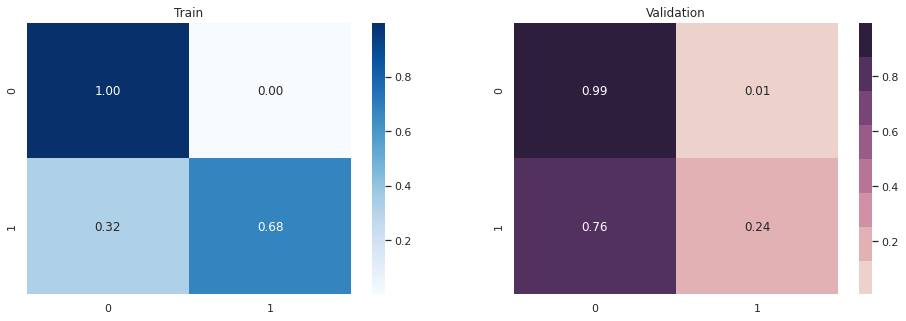

Fold: 2


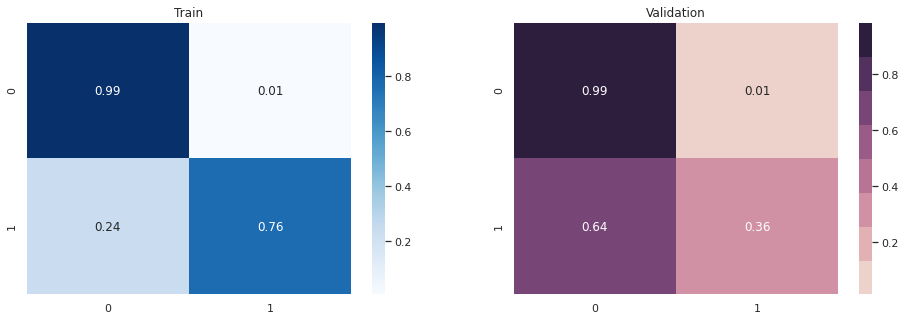

Fold: 3


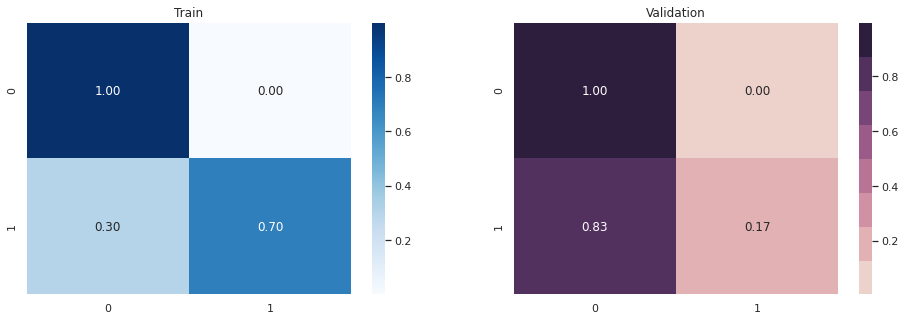

In [25]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [26]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.018149,0.027389,0.028700,0.034656
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.014600,0.019062,0.022266,0.031674
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.017467,0.031287,0.024100,0.031948
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.017954,0.033554,0.025966,0.030249
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.015044,0.022613,0.025026,0.027580
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.016715,0.025861,0.025369,0.032346
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.016580,0.023160,0.032707,0.027033
7,ISIC_0075663,female,35.0,torso,unknown,0,0.015208,0.026017,0.023770,0.026251
8,ISIC_0075914,male,30.0,torso,unknown,0,0.015610,0.024194,0.023709,0.030146
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.015248,0.026349,0.021278,0.028613


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.016222,0.022109,0.026691,0.032312
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.244659,0.157331,0.294465,0.771499
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.263443,0.310218,0.075308,0.931692
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.490435,0.843405,0.707788,0.900980
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.420894,0.945880,0.981078,0.177514
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.452900,0.323272,0.987101,0.954126
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.187214,0.031682,0.405382,0.499008
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.379860,0.291126,0.735871,0.872305
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.327923,0.445089,0.956895,0.237630
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.267397,0.926875,0.374886,0.035226


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.572406,0.953403,0.950651,0.957977
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.559621,0.957136,0.948352,0.892619
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.585543,0.977621,0.980732,0.969363
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.561613,0.961010,0.936371,0.910686
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.578133,0.954132,0.974982,0.961553
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.577365,0.965934,0.964613,0.956277
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.589458,0.985827,0.981727,0.979735
1873,ISIC_0662000,male,40.0,torso,melanoma,1,0.519095,0.928382,0.769795,0.897297
2143,ISIC_0744013,female,65.0,upper extremity,melanoma,1,0.558030,0.852003,0.970925,0.967220
2709,ISIC_0911264,male,65.0,lower extremity,melanoma,1,0.572441,0.951027,0.949517,0.961662


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 183
Train positive correct predictions: 183


# Make predictions (best)

In [27]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'model' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/model_fold_3.h5


In [28]:
#@title
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/model_fold_1.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/model_fold_2.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/model_fold_3.h5
Running TTA


# Make predictions (last)

In [29]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'last' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/last_model_fold_3.h5


In [30]:
#@title
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/last_model_fold_1.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/last_model_fold_2.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/42-efficientnetb0/last_model_fold_3.h5
Running TTA


# Visualize test predictions

In [33]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 111|10871
Test predictions (last) 118|10864
Test predictions (tta) 95|10887
Test predictions (last tta) 105|10877
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.026192,0.022614,0.026840,0.024075
1,ISIC_0052349,male,40.0,lower extremity,0.028211,0.024555,0.027526,0.024133
2,ISIC_0058510,female,55.0,torso,0.026663,0.024426,0.026605,0.025698
3,ISIC_0073313,female,50.0,torso,0.027304,0.024856,0.027145,0.024280
4,ISIC_0073502,female,45.0,lower extremity,0.028220,0.028006,0.028603,0.027773
5,ISIC_0074618,male,50.0,lower extremity,0.044097,0.041537,0.031102,0.029555
6,ISIC_0076801,male,45.0,upper extremity,0.029835,0.026449,0.029910,0.025697
7,ISIC_0077586,male,50.0,lower extremity,0.035435,0.034137,0.069660,0.099488
8,ISIC_0082004,female,45.0,torso,0.028361,0.025282,0.028827,0.027352
9,ISIC_0082785,male,65.0,lower extremity,0.026590,0.026929,0.027524,0.028170


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.840628,0.897481,0.861946,0.753566
102,ISIC_0208233,female,60.0,lower extremity,0.975251,0.958022,0.966780,0.961137
255,ISIC_0351156,male,40.0,head/neck,0.865396,0.870684,0.787077,0.812788
296,ISIC_0391046,male,85.0,torso,0.555177,0.556216,0.544984,0.604856
403,ISIC_0481105,male,80.0,torso,0.761911,0.859850,0.899773,0.869992
453,ISIC_0524466,female,30.0,head/neck,0.639999,0.399547,0.516673,0.345337
471,ISIC_0539432,female,45.0,lower extremity,0.967901,0.965697,0.965401,0.962322
552,ISIC_0606244,male,70.0,torso,0.959275,0.955478,0.748915,0.778102
596,ISIC_0637104,female,80.0,torso,0.604062,0.700630,0.503432,0.586860
764,ISIC_0775584,female,35.0,lower extremity,0.565668,0.367910,0.543222,0.417979


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.840628,0.897481,0.861946,0.753566
102,ISIC_0208233,female,60.0,lower extremity,0.975251,0.958022,0.966780,0.961137
255,ISIC_0351156,male,40.0,head/neck,0.865396,0.870684,0.787077,0.812788
296,ISIC_0391046,male,85.0,torso,0.555177,0.556216,0.544984,0.604856
403,ISIC_0481105,male,80.0,torso,0.761911,0.859850,0.899773,0.869992
471,ISIC_0539432,female,45.0,lower extremity,0.967901,0.965697,0.965401,0.962322
552,ISIC_0606244,male,70.0,torso,0.959275,0.955478,0.748915,0.778102
596,ISIC_0637104,female,80.0,torso,0.604062,0.700630,0.503432,0.586860
860,ISIC_0867509,female,80.0,torso,0.430168,0.549352,0.148155,0.135824
926,ISIC_0925021,male,70.0,torso,0.641660,0.686557,0.530603,0.585730


# Test set predictions

In [32]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.026192,0.022614,0.024403,0.026840,0.024075,0.025457
1,ISIC_0052349,0.028211,0.024555,0.026383,0.027526,0.024133,0.025830
2,ISIC_0058510,0.026663,0.024426,0.025544,0.026605,0.025698,0.026151
3,ISIC_0073313,0.027304,0.024856,0.026080,0.027145,0.024280,0.025713
4,ISIC_0073502,0.028220,0.028006,0.028113,0.028603,0.027773,0.028188
5,ISIC_0074618,0.044097,0.041537,0.042817,0.031102,0.029555,0.030329
6,ISIC_0076801,0.029835,0.026449,0.028142,0.029910,0.025697,0.027804
7,ISIC_0077586,0.035435,0.034137,0.034786,0.069660,0.099488,0.084574
8,ISIC_0082004,0.028361,0.025282,0.026822,0.028827,0.027352,0.028090
9,ISIC_0082785,0.026590,0.026929,0.026760,0.027524,0.028170,0.027847


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.044998,0.047244,0.046121,0.046578,0.048200,0.047389
std,0.082921,0.088741,0.084499,0.078655,0.083484,0.079909
min,0.022957,0.020829,0.022323,0.023717,0.022303,0.023389
25%,0.027534,0.025727,0.026671,0.027891,0.026184,0.027094
50%,0.029226,0.027787,0.028560,0.030088,0.028810,0.029481
75%,0.032807,0.032175,0.032717,0.035011,0.034447,0.035051
max,0.982025,0.983016,0.981731,0.981738,0.980289,0.981013
